In [13]:
import numpy as np
import matplotlib.pyplot as plt

from ppfft import ppfft, adj_ppfft


Let $y$ be the pseudo-polar Fourier transform of an image. In order to find the original image, we want to minimize the following cost:
$$
c(x) = \|\mathcal{F}_\text{pp}(x) - y\|^2
$$

where $\mathcal{F}_\text{pp}$ is the pseudo-polar Fourier transform. The gradient of this function is:
$$
\nabla c(x) = 2 \mathcal{F}_\text{pp}^{\dagger} \left( \mathcal{F}_\text{pp} (x) - y\right)
$$

which is equal to zero when:
$$
\mathcal{F}_\text{pp}^\dagger \circ \mathcal{F}_\text{pp} (x) = \mathcal{F}_\text{pp}^* (y)
$$

In [14]:
from scipy.sparse.linalg import cg, LinearOperator


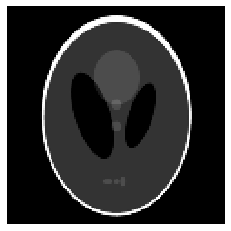

In [15]:
im = plt.imread("Shepp_logan_240.png")
im = im[::2, ::2]
plt.imshow(im, cmap="gray")
plt.axis("off")
plt.show()


In [16]:
n = im.shape[0]
assert n % 2 == 0
m = 2 * n + 1


In order to use scipy's conjugate gradient implementation, the operator $\mathcal{F}_{\text{pp}}^{\dagger} \circ \mathcal{F}_{\text{pp}}$ has to take as input a 1D vector and outputs a 1D vector too. This is implemented in the following function:

In [25]:
def vec_operator(v):
    a = np.reshape(v, newshape=(n, n))
    hori, vert = ppfft(a)
    b = adj_ppfft(hori, vert)
    return b.flatten()


We now use scipy's linear operator class to define the operator $\mathcal{F}_{\text{pp}}^{\dagger} \circ \mathcal{F}_{\text{pp}}$:

In [26]:
operator = LinearOperator(
    shape=(n**2, n**2), matvec=vec_operator, rmatvec=vec_operator)


We initialize the target and compute the solution:

In [27]:
y = vec_operator(im.flatten())
sol = np.reshape(cg(operator, y, x0=np.zeros(n**2), tol=1e-7)[0], (n, n))


We now do the same, but we add the preconditioner $M$ used in the paper:

In [24]:
M = np.empty(shape=(n+1, m))

for k in range(m):
    if k - n == 0:
        M[:, k] = 1 / m**2
    else:
        M[:, k] = 2 * (n + 1) * abs(k - n) / (n * m)


We define the new operator and solve the problem:

In [29]:
def vec_operator_preconditioned(v):
    a = np.reshape(v, newshape=(n, n))
    hori, vert = ppfft(a)
    b = adj_ppfft(M * hori, M * vert)
    return b.flatten()


operator_preconditioned = LinearOperator(
    shape=(n**2, n**2), matvec=vec_operator_preconditioned, rmatvec=vec_operator_preconditioned)

y = vec_operator_preconditioned(im.flatten())


In [32]:
sol_preconditioned = np.reshape(
    cg(operator_preconditioned, y, x0=np.zeros(n**2), tol=1e-7)[0], (n, n))


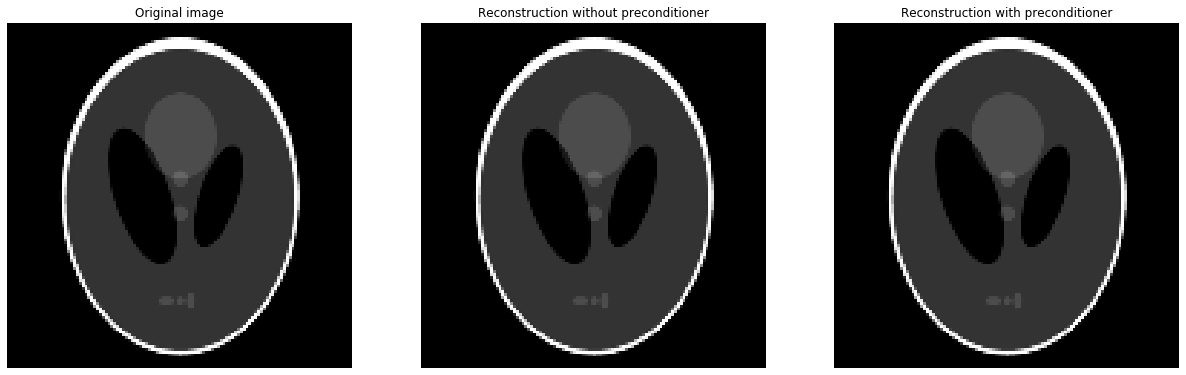

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

axes[0].imshow(im, cmap='gray')
axes[0].set_title("Original image")
axes[0].set_axis_off()
axes[1].imshow(sol.real, cmap='gray')
axes[1].set_title("Reconstruction without preconditioner")
axes[1].set_axis_off()
axes[2].imshow(sol_preconditioned.real, cmap='gray')
axes[2].set_title("Reconstruction with preconditioner")
axes[2].set_axis_off()


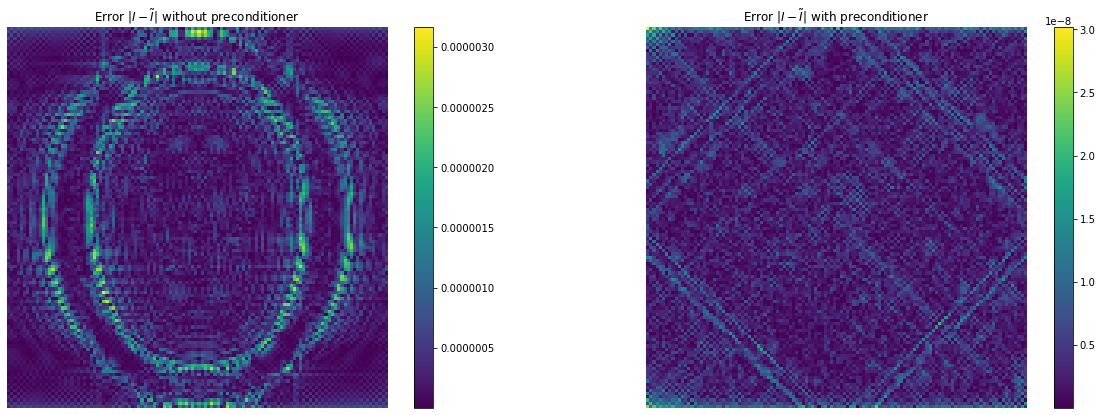

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(21, 7))

im1 = axes[0].imshow(np.abs(im - np.real(sol)))
axes[0].set_title(r"Error $|I - \tilde{I}|$ without preconditioner")
axes[0].set_axis_off()
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(np.abs(im - np.real(sol_preconditioned)))
axes[1].set_title(r"Error $|I - \tilde{I}|$ with preconditioner")
axes[1].set_axis_off()
plt.colorbar(im2, ax=axes[1])

plt.show()


We define two reconstruction errors:

In [17]:
def E2(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed)**2) / np.sum(original**2))


def Einf(original, reconstructed):
    return np.max(np.abs(original - reconstructed)) / np.max(np.abs(original))


In [18]:
print(E2(im, sol))
print(Einf(im, sol))


(2.5626931685829923e-06-4.212421752877589e-10j)
3.1655488010799026e-06


In [19]:
print(E2(im, sol_preconditioned))
print(Einf(im, sol_preconditioned))


(1.8685011532026197e-08-1.8229308406149545e-16j)
3.016613098296467e-08


# (240, 240) image

In [18]:
im240 = plt.imread("Shepp_logan_240.png")
n = im240.shape[0]
m = 2*n + 1

M = np.empty(shape=(n+1, m))

for k in range(m):
    if k - n == 0:
        M[:, k] = 1 / m**2
    else:
        M[:, k] = 2 * (n + 1) * abs(k - n) / (n * m)


In [19]:
operator_preconditioned = LinearOperator(
    shape=(n**2, n**2), matvec=vec_operator_preconditioned, rmatvec=vec_operator_preconditioned)


In [20]:
y = vec_operator_preconditioned(im240.flatten())
sol_240 = np.reshape(
    cg(operator_preconditioned, y, x0=np.zeros(n**2), tol=1e-7)[0], (n, n))


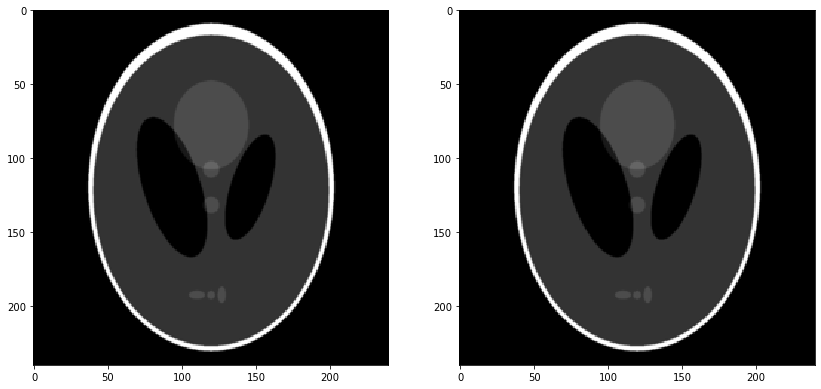

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(im240, cmap='gray')
axes[1].imshow(sol_240.real, cmap='gray')

plt.show()


In [22]:
np.max(np.abs(im240 - sol_240.real))


4.876011465502364e-08